# MARATONA BEHIND THE CODE 2020

## DESAFIO 7: TNT

## Testes com modelo XGBoost Otimizado

# Parte 01. Importando as bibliotecas

In [1]:
# Pacotes padrao
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote do sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pacote ML
from xgboost import XGBClassifier
import xgboost as xgb

# Pacote para balanceamento dos dados
from imblearn.over_sampling import SMOTE

# Pacote para hyperparametros
import optuna
import functools

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')

# Parte 02. Carregando o dataset de treino

In [2]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
treino = pd.read_csv(r'train_17015.csv')
print('Quantidade de registros e colunas: ',treino.shape)
treino.head()

Quantidade de registros e colunas:  (17015, 15)


,Tempo,Estacao,LAT,LONG,Movimentacao,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET,row
0,2019-12-30,Fradique Coutinho,-23.5661,-46.6841,35386,24,45,61,42,19,22,15,9,NORMAL,10800
1,2018-01-08,Luz,-23.5365,-46.6332,124806,15,10,10,29,10,25,14,13,NORMAL,10808
2,2018-04-17,Luz,-23.5365,-46.6332,125215,53,1,55,18,18,6,37,8,REABASTECER,10907
3,2018-07-18,Luz,-23.5365,-46.6332,126476,36,5,57,38,15,43,43,18,REABASTECER,10998
4,2018-08-28,Luz,-23.5365,-46.6332,125917,79,10,8,37,32,30,18,15,NORMAL,11038


In [3]:
# Visualizando o tipo dos dados
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tempo         16921 non-null  object 
 1   Estacao       17015 non-null  object 
 2   LAT           17015 non-null  float64
 3   LONG          17015 non-null  float64
 4   Movimentacao  17015 non-null  int64  
 5   Original_473  17015 non-null  int64  
 6   Original_269  17015 non-null  int64  
 7   Zero          17015 non-null  int64  
 8   Maca_Verde    17015 non-null  int64  
 9   Tangerina     17015 non-null  int64  
 10  Citrus        17015 non-null  int64  
 11  Acai_Guarana  17015 non-null  int64  
 12  Pessego       17015 non-null  int64  
 13  TARGET        17015 non-null  object 
 14  row           17015 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.9+ MB


,TARGET,%
NORMAL,11517,67.687
REABASTECER,5498,32.313


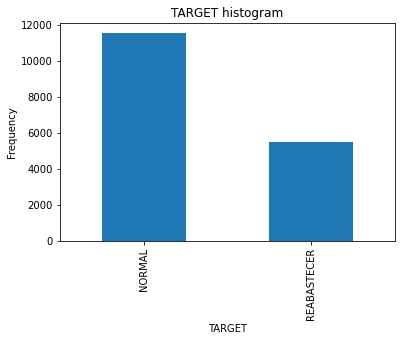

In [4]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

# Parte 03. Feature Engineering

In [5]:
# Removendo colunas que não serão utilizadas no treinamento
treino = treino.drop(['Tempo','Estacao','Movimentacao','LAT','LONG', 'row'], axis = 1)

# Converte colunas para numerico
treino = treino.apply(pd.to_numeric, errors='ignore')

# Visualizando os primeiros registros
treino.head()

,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET
0,24,45,61,42,19,22,15,9,NORMAL
1,15,10,10,29,10,25,14,13,NORMAL
2,53,1,55,18,18,6,37,8,REABASTECER
3,36,5,57,38,15,43,43,18,REABASTECER
4,79,10,8,37,32,30,18,15,NORMAL


# Parte 04. Modelagem Preditiva
> - Nesta fase estarei construindo os modelos preditivos
> - Vou utilizar o modelo XGB para treinamento

In [44]:
# Definindo alguns parametros
SEED  = 42

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

#### ***** Função para criar os dados de treino e teste/validação utilizando amostragem estratificada:
####
def train_test_split_strat(data, target, n_splits=1, test_size=0.2, random_state=42):
    # Criando a instância:
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    # Criando os datasets de treino e teste utilizando amostragem estratificada:
    for train_index, test_index in split.split(data, data[target]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]

    # Reset no índice do dataset de treino:
    strat_train_set.reset_index(drop=True, inplace=True)

    # Reset no índice do dataset de teste:
    strat_test_set.reset_index(drop=True, inplace=True)

    # Definição das colunas que serão features (variáveis preditoras):
    features = list(data.columns) # cria uma lista com todas as variáveis do dataset.
    features.remove(target) # remove a variável target.

    # Criação dos dados de treino:
    X_train = strat_train_set[features]
    y_train = strat_train_set[target]

    # Criação dos dados de teste:
    X_test = strat_test_set[features]
    y_test = strat_test_set[target]
    
    # Mostrando o resultado (número de observações em cada dataset):
    print(len(strat_train_set), "train +", len(strat_test_set), "test/valid", "=", (len(strat_train_set)+len(strat_test_set)),
          "total")
    
    y_train = y_train.astype("category").cat.codes
    y_test = y_test.astype("category").cat.codes
    
    
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    # Retorna os dados de treino e teste:
    return (X_train, y_train, X_test, y_test)
    

In [8]:
# Split dos dados
X_treino, y_treino, X_teste, y_teste = train_test_split_strat(treino, 'TARGET', test_size = .2, random_state = SEED)    

13612 train + 3403 test/valid = 17015 total


### Sem Balanceamento dos dados

Acurácia: 74.67%
Sensibilidade : 0.6927272727272727
Especificidade : 0.7724706904038211


              precision    recall  f1-score   support

           0       0.84      0.77      0.80      2303
           1       0.59      0.69      0.64      1100

    accuracy                           0.75      3403
   macro avg       0.72      0.73      0.72      3403
weighted avg       0.76      0.75      0.75      3403



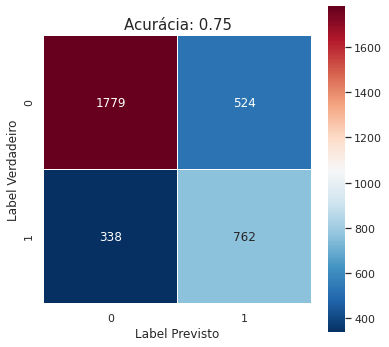

In [9]:
# Criando o modelo
modelo_xgb_v1 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v1.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v1.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v1 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v1 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v1), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Com Balanceamento dos dados

In [10]:
# Aplicando a funcao SMOTE
sm = SMOTE(random_state=SEED)
X_treino_bal, y_treino_bal = sm.fit_sample(X_treino, y_treino)

Acurácia: 65.24%
Sensibilidade : 0.9963636363636363
Especificidade : 0.48805905340859745


              precision    recall  f1-score   support

           0       1.00      0.49      0.66      2303
           1       0.48      1.00      0.65      1100

    accuracy                           0.65      3403
   macro avg       0.74      0.74      0.65      3403
weighted avg       0.83      0.65      0.65      3403



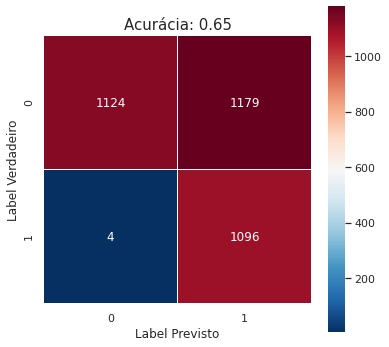

In [11]:
# Criando o modelo
modelo_xgb_v2 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v2.fit(X_treino_bal, y_treino_bal)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v2.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v2 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v2 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v2), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Identificando os melhores Hyperparametros

In [12]:
def objective(trial):

    dtrain = xgb.DMatrix(X_treino, label=y_treino)
    dvalid = xgb.DMatrix(X_teste, label=y_teste)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_teste, pred_labels)
    return accuracy

In [13]:
study_v2 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=15), direction="maximize")
study_v2.optimize(objective, n_trials=100)
print(study_v2.best_trial)

[I 2020-09-11 19:44:09,064] A new study created in memory with name: no-name-9ae50092-bc3f-4180-ab71-e2e0c941306e


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.56019
[1]	validation-auc:0.62273
[2]	validation-auc:0.66458
[3]	validation-auc:0.71595
[4]	validation-auc:0.75906
[5]	validation-auc:0.78946
[6]	validation-auc:0.78411
[7]	validation-auc:0.78453
[8]	validation-auc:0.78655
[9]	validation-auc:0.78771


[I 2020-09-11 19:44:09,100] Trial 0 finished with value: 0.677343520423156 and parameters: {'booster': 'gbtree', 'lambda': 0.00019809022364808055, 'alpha': 0.3708477195638143, 'max_depth': 1, 'eta': 0.0838913748090856, 'gamma': 9.45584168528639e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.677343520423156.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83222
[1]	validation-auc:0.83475
[2]	validation-auc:0.83484
[3]	validation-auc:0.83475
[4]	validation-auc:0.83477
[5]	validation-auc:0.83474
[6]	validation-auc:0.83467
[7]	validation-auc:0.83464
[8]	validation-auc:0.83458
[9]	validation-auc:0.83447


[I 2020-09-11 19:44:09,166] Trial 1 finished with value: 0.7707904789891272 and parameters: {'booster': 'gbtree', 'lambda': 0.0035730135251895077, 'alpha': 0.009429722820133235, 'max_depth': 8, 'eta': 3.4153507953022895e-05, 'gamma': 6.599028958807185e-08, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.66490
[1]	validation-auc:0.66477
[2]	validation-auc:0.66466
[3]	validation-auc:0.66462
[4]	validation-auc:0.66457
[5]	validation-auc:0.66453
[6]	validation-auc:0.66451
[7]	validation-auc:0.66450
[8]	validation-auc:0.66448
[9]	validation-auc:0.66449


[I 2020-09-11 19:44:09,193] Trial 2 finished with value: 0.6788128122245077 and parameters: {'booster': 'gblinear', 'lambda': 1.9346155657907527e-08, 'alpha': 0.00015570093203299526}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.66490
[1]	validation-auc:0.66479
[2]	validation-auc:0.66469
[3]	validation-auc:0.66465
[4]	validation-auc:0.66460
[5]	validation-auc:0.66457
[6]	validation-auc:0.66454
[7]	validation-auc:0.66454
[8]	validation-auc:0.66452
[9]	validation-auc:0.66451


[I 2020-09-11 19:44:09,220] Trial 3 finished with value: 0.6779312371436967 and parameters: {'booster': 'gblinear', 'lambda': 0.016808139346582388, 'alpha': 8.467101919272575e-05}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.56019
[1]	validation-auc:0.62610
[2]	validation-auc:0.67995
[3]	validation-auc:0.71800
[4]	validation-auc:0.76131
[5]	validation-auc:0.79062
[6]	validation-auc:0.82118
[7]	validation-auc:0.84534
[8]	validation-auc:0.83645
[9]	validation-auc:0.83780


[I 2020-09-11 19:44:09,249] Trial 4 finished with value: 0.7155451072583014 and parameters: {'booster': 'gbtree', 'lambda': 1.7521146941021935e-08, 'alpha': 0.0025660311925455987, 'max_depth': 1, 'eta': 0.5650171322426556, 'gamma': 9.752266896866523e-06, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.75819
[1]	validation-auc:0.75819
[2]	validation-auc:0.75819
[3]	validation-auc:0.75819
[4]	validation-auc:0.75819
[5]	validation-auc:0.75819
[6]	validation-auc:0.75819
[7]	validation-auc:0.75819
[8]	validation-auc:0.75819
[9]	validation-auc:0.75819


[I 2020-09-11 19:44:09,296] Trial 5 finished with value: 0.7534528357331766 and parameters: {'booster': 'gbtree', 'lambda': 0.05698246526989181, 'alpha': 0.00013664310704183396, 'max_depth': 5, 'eta': 0.00013539068403152613, 'gamma': 0.0006687937025075689, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67773
[1]	validation-auc:0.67773
[2]	validation-auc:0.67773
[3]	validation-auc:0.67773
[4]	validation-auc:0.67773
[5]	validation-auc:0.67773
[6]	validation-auc:0.67773
[7]	validation-auc:0.67773
[8]	validation-auc:0.67773
[9]	validation-auc:0.67773


[I 2020-09-11 19:44:09,331] Trial 6 finished with value: 0.7278871583896562 and parameters: {'booster': 'gbtree', 'lambda': 0.0005707871295722409, 'alpha': 8.299415171879432e-05, 'max_depth': 3, 'eta': 6.662559411843497e-05, 'gamma': 0.0038031214587128616, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.61731
[1]	validation-auc:0.61656
[2]	validation-auc:0.61598
[3]	validation-auc:0.61698
[4]	validation-auc:0.61598
[5]	validation-auc:0.61698
[6]	validation-auc:0.61698
[7]	validation-auc:0.61698
[8]	validation-auc:0.61698
[9]	validation-auc:0.61698


[I 2020-09-11 19:44:09,364] Trial 7 finished with value: 0.7079047898912724 and parameters: {'booster': 'dart', 'lambda': 3.6567054127739024e-08, 'alpha': 1.1209854357197475e-05, 'max_depth': 2, 'eta': 2.0830184781889627e-07, 'gamma': 0.6119226768383735, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0488904357697837e-06, 'skip_drop': 0.06717740855937797}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.61698
[1]	validation-auc:0.72361
[2]	validation-auc:0.78868
[3]	validation-auc:0.84184
[4]	validation-auc:0.83710
[5]	validation-auc:0.83965
[6]	validation-auc:0.84012
[7]	validation-auc:0.83580
[8]	validation-auc:0.83864
[9]	validation-auc:0.84025


[I 2020-09-11 19:44:09,397] Trial 8 finished with value: 0.7055539230091096 and parameters: {'booster': 'gbtree', 'lambda': 0.11795276288740603, 'alpha': 0.0001364752064500161, 'max_depth': 2, 'eta': 0.22401966096485063, 'gamma': 0.06584254741560346, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50338
[9]	validation-auc:0.50338


[I 2020-09-11 19:44:09,430] Trial 9 finished with value: 0.6758742286218042 and parameters: {'booster': 'dart', 'lambda': 2.597448055223057e-06, 'alpha': 0.004615976206256965, 'max_depth': 2, 'eta': 1.5618797114870748e-08, 'gamma': 0.35255936674507327, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.9947306165672413e-07, 'skip_drop': 1.9690751985759038e-08}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82548
[1]	validation-auc:0.82689
[2]	validation-auc:0.82753
[3]	validation-auc:0.82748
[4]	validation-auc:0.82756
[5]	validation-auc:0.82783
[6]	validation-auc:0.82814
[7]	validation-auc:0.82796
[8]	validation-auc:0.82782
[9]	validation-auc:0.82784


[I 2020-09-11 19:44:09,521] Trial 10 finished with value: 0.7622685865412872 and parameters: {'booster': 'gbtree', 'lambda': 6.160037057913825e-06, 'alpha': 1.1664508348493377e-08, 'max_depth': 9, 'eta': 6.776456529063336e-05, 'gamma': 1.0970677304383462e-08, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82547
[1]	validation-auc:0.82687
[2]	validation-auc:0.82755
[3]	validation-auc:0.82747
[4]	validation-auc:0.82764
[5]	validation-auc:0.82784
[6]	validation-auc:0.82789
[7]	validation-auc:0.82792
[8]	validation-auc:0.82772
[9]	validation-auc:0.82780


[I 2020-09-11 19:44:09,612] Trial 11 finished with value: 0.7631501616220981 and parameters: {'booster': 'gbtree', 'lambda': 4.068825969700985e-06, 'alpha': 1.7767524432802193e-08, 'max_depth': 9, 'eta': 5.20555956122145e-05, 'gamma': 1.4078613966375594e-08, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82530
[1]	validation-auc:0.82673
[2]	validation-auc:0.82727
[3]	validation-auc:0.82739
[4]	validation-auc:0.82730
[5]	validation-auc:0.82721
[6]	validation-auc:0.82732
[7]	validation-auc:0.82724
[8]	validation-auc:0.82720
[9]	validation-auc:0.82721


[I 2020-09-11 19:44:09,701] Trial 12 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 2.4678883633460015e-06, 'alpha': 1.62333247884323e-08, 'max_depth': 9, 'eta': 4.729890721877061e-06, 'gamma': 8.889326543691509e-07, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80736
[1]	validation-auc:0.80882
[2]	validation-auc:0.80914
[3]	validation-auc:0.80910
[4]	validation-auc:0.80867
[5]	validation-auc:0.80884
[6]	validation-auc:0.80879
[7]	validation-auc:0.80894
[8]	validation-auc:0.80891
[9]	validation-auc:0.80890


[I 2020-09-11 19:44:09,773] Trial 13 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 0.0030257447806490002, 'alpha': 5.15685505507967e-07, 'max_depth': 7, 'eta': 1.0702934861024658e-06, 'gamma': 1.0037694049341293e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-11 19:44:09,814] Trial 14 finished with value: 0.6767558037026153 and parameters: {'booster': 'gblinear', 'lambda': 0.9286805939217021, 'alpha': 0.27440057917331634}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80709
[1]	validation-auc:0.80709
[2]	validation-auc:0.80709
[3]	validation-auc:0.80819
[4]	validation-auc:0.80785
[5]	validation-auc:0.80766
[6]	validation-auc:0.80756
[7]	validation-auc:0.80751
[8]	validation-auc:0.80750
[9]	validation-auc:0.80752


[I 2020-09-11 19:44:09,893] Trial 15 finished with value: 0.7610931531002058 and parameters: {'booster': 'dart', 'lambda': 2.3797446692768322e-07, 'alpha': 0.0051299154149043276, 'max_depth': 7, 'eta': 0.002614683412161971, 'gamma': 1.725480008387828e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.7032524327078138, 'skip_drop': 1.3238545247385335e-08}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80942
[1]	validation-auc:0.80890
[2]	validation-auc:0.80934
[3]	validation-auc:0.80938
[4]	validation-auc:0.80947
[5]	validation-auc:0.80956
[6]	validation-auc:0.80952
[7]	validation-auc:0.80955
[8]	validation-auc:0.80956
[9]	validation-auc:0.80956


[I 2020-09-11 19:44:09,966] Trial 16 finished with value: 0.7616808698207465 and parameters: {'booster': 'gbtree', 'lambda': 3.659941959939943e-05, 'alpha': 0.04104966333283095, 'max_depth': 7, 'eta': 1.4766718936621212e-06, 'gamma': 2.1326745901340416e-07, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7707904789891272.


[19:44:09] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83033
[1]	validation-auc:0.83121
[2]	validation-auc:0.83169
[3]	validation-auc:0.83227
[4]	validation-auc:0.83177
[5]	validation-auc:0.83194
[6]	validation-auc:0.83174
[7]	validation-auc:0.83476
[8]	validation-auc:0.83224
[9]	validation-auc:0.83166


[I 2020-09-11 19:44:10,051] Trial 17 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0023147389075111784, 'alpha': 1.9050355011300542e-07, 'max_depth': 8, 'eta': 3.9157335892730676e-06, 'gamma': 2.6610461449517375e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.75689
[1]	validation-auc:0.75689
[2]	validation-auc:0.75689
[3]	validation-auc:0.75694
[4]	validation-auc:0.75675
[5]	validation-auc:0.75638
[6]	validation-auc:0.75662
[7]	validation-auc:0.75570
[8]	validation-auc:0.78542
[9]	validation-auc:0.78580


[I 2020-09-11 19:44:10,112] Trial 18 finished with value: 0.753746694093447 and parameters: {'booster': 'gbtree', 'lambda': 0.0036027464607482408, 'alpha': 3.8427780489005224e-07, 'max_depth': 5, 'eta': 0.003863453370815488, 'gamma': 7.351902783119125e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50507
[4]	validation-auc:0.51501
[5]	validation-auc:0.52132
[6]	validation-auc:0.83233
[7]	validation-auc:0.83383
[8]	validation-auc:0.83289
[9]	validation-auc:0.82946


[I 2020-09-11 19:44:10,192] Trial 19 finished with value: 0.6967381722009991 and parameters: {'booster': 'gbtree', 'lambda': 0.0011622310168292083, 'alpha': 3.914522603488873e-07, 'max_depth': 8, 'eta': 1.2946334875997809e-08, 'gamma': 2.6020661176585512e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.60747
[1]	validation-auc:0.60740
[2]	validation-auc:0.60736
[3]	validation-auc:0.60734
[4]	validation-auc:0.60732
[5]	validation-auc:0.60731
[6]	validation-auc:0.60730
[7]	validation-auc:0.60730
[8]	validation-auc:0.60729
[9]	validation-auc:0.60729


[I 2020-09-11 19:44:10,226] Trial 20 finished with value: 0.6767558037026153 and parameters: {'booster': 'gblinear', 'lambda': 0.9660256065708213, 'alpha': 0.04707817188180806}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83036
[1]	validation-auc:0.83118
[2]	validation-auc:0.83182
[3]	validation-auc:0.83165
[4]	validation-auc:0.83167
[5]	validation-auc:0.83162
[6]	validation-auc:0.83164
[7]	validation-auc:0.83166
[8]	validation-auc:0.83167
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:10,310] Trial 21 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 3.8052020893515495e-05, 'alpha': 4.29580204519689e-08, 'max_depth': 8, 'eta': 5.01412623841835e-06, 'gamma': 3.1661369933403182e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83027
[1]	validation-auc:0.83131
[2]	validation-auc:0.83173
[3]	validation-auc:0.83167
[4]	validation-auc:0.83169
[5]	validation-auc:0.83166
[6]	validation-auc:0.83168
[7]	validation-auc:0.83166
[8]	validation-auc:0.83169
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:10,395] Trial 22 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 5.161663065556302e-05, 'alpha': 2.2288645978294762e-06, 'max_depth': 8, 'eta': 1.1701920340690428e-05, 'gamma': 0.000491562474026714, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78583
[1]	validation-auc:0.78285
[2]	validation-auc:0.78537
[3]	validation-auc:0.78652
[4]	validation-auc:0.78505
[5]	validation-auc:0.78610
[6]	validation-auc:0.78685
[7]	validation-auc:0.78462
[8]	validation-auc:0.78469
[9]	validation-auc:0.78658


[I 2020-09-11 19:44:10,462] Trial 23 finished with value: 0.7572729944166912 and parameters: {'booster': 'gbtree', 'lambda': 2.7482492449635078e-05, 'alpha': 2.827928075086255e-06, 'max_depth': 6, 'eta': 2.2601956814960407e-07, 'gamma': 0.0005172000380098577, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83083
[1]	validation-auc:0.83159
[2]	validation-auc:0.83179
[3]	validation-auc:0.83173
[4]	validation-auc:0.83157
[5]	validation-auc:0.83167
[6]	validation-auc:0.83164
[7]	validation-auc:0.83162
[8]	validation-auc:0.83172
[9]	validation-auc:0.83161


[I 2020-09-11 19:44:10,542] Trial 24 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0001238953692321341, 'alpha': 7.63740433533734e-08, 'max_depth': 8, 'eta': 2.8942723407183657e-06, 'gamma': 0.004549784283712054, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78584
[1]	validation-auc:0.78518
[2]	validation-auc:0.78518
[3]	validation-auc:0.78518
[4]	validation-auc:0.78518
[5]	validation-auc:0.78518
[6]	validation-auc:0.78518
[7]	validation-auc:0.78518
[8]	validation-auc:0.78518
[9]	validation-auc:0.78518


[I 2020-09-11 19:44:10,613] Trial 25 finished with value: 0.7572729944166912 and parameters: {'booster': 'dart', 'lambda': 0.00011247027035327437, 'alpha': 9.000524324726705e-08, 'max_depth': 6, 'eta': 0.0006214360309155197, 'gamma': 0.010304810507133121, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.40150138747856046, 'skip_drop': 0.0002770476005730217}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83040
[1]	validation-auc:0.83139
[2]	validation-auc:0.83181
[3]	validation-auc:0.83169
[4]	validation-auc:0.83170
[5]	validation-auc:0.83166
[6]	validation-auc:0.83169
[7]	validation-auc:0.83166
[8]	validation-auc:0.83169
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:10,692] Trial 26 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 2.3628239432278586e-07, 'alpha': 3.455466737146321e-06, 'max_depth': 8, 'eta': 8.716356892957435e-06, 'gamma': 6.580820869767294e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78502
[1]	validation-auc:0.78471
[2]	validation-auc:0.78504
[3]	validation-auc:0.78588
[4]	validation-auc:0.78486
[5]	validation-auc:0.78658
[6]	validation-auc:0.78602
[7]	validation-auc:0.78488
[8]	validation-auc:0.78656
[9]	validation-auc:0.78611


[I 2020-09-11 19:44:10,757] Trial 27 finished with value: 0.7572729944166912 and parameters: {'booster': 'gbtree', 'lambda': 2.7268106788266967e-07, 'alpha': 3.568523247024329e-06, 'max_depth': 6, 'eta': 4.745410522819603e-07, 'gamma': 0.0003066743030343787, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82515
[1]	validation-auc:0.82272
[2]	validation-auc:0.82570
[3]	validation-auc:0.82389
[4]	validation-auc:0.82494
[5]	validation-auc:0.82545
[6]	validation-auc:0.82733
[7]	validation-auc:0.82715
[8]	validation-auc:0.82730
[9]	validation-auc:0.82799


[I 2020-09-11 19:44:10,844] Trial 28 finished with value: 0.7590361445783133 and parameters: {'booster': 'gbtree', 'lambda': 1.583220074369907e-05, 'alpha': 3.009880923751798e-08, 'max_depth': 9, 'eta': 1.2053026344349746e-07, 'gamma': 0.003683241715415122, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80692
[1]	validation-auc:0.80829
[2]	validation-auc:0.80887
[3]	validation-auc:0.80905
[4]	validation-auc:0.80892
[5]	validation-auc:0.80895
[6]	validation-auc:0.80902
[7]	validation-auc:0.80898
[8]	validation-auc:0.80903
[9]	validation-auc:0.80908


[I 2020-09-11 19:44:10,914] Trial 29 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 0.00026001427467746446, 'alpha': 6.424538198040193e-08, 'max_depth': 7, 'eta': 1.450269439133771e-05, 'gamma': 0.015520020678401997, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.72187
[1]	validation-auc:0.72187
[2]	validation-auc:0.72187
[3]	validation-auc:0.72187
[4]	validation-auc:0.72187
[5]	validation-auc:0.72187
[6]	validation-auc:0.72187
[7]	validation-auc:0.72187
[8]	validation-auc:0.72187
[9]	validation-auc:0.72187


[I 2020-09-11 19:44:10,969] Trial 30 finished with value: 0.7437555098442551 and parameters: {'booster': 'gbtree', 'lambda': 4.808159032699084e-07, 'alpha': 1.404416929901819e-05, 'max_depth': 4, 'eta': 0.00031161285525184706, 'gamma': 5.8054955847246805e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83030
[1]	validation-auc:0.83113
[2]	validation-auc:0.83166
[3]	validation-auc:0.83171
[4]	validation-auc:0.83170
[5]	validation-auc:0.83166
[6]	validation-auc:0.83169
[7]	validation-auc:0.83160
[8]	validation-auc:0.83169
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:11,049] Trial 31 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 6.553562420116243e-05, 'alpha': 2.2336109951161937e-06, 'max_depth': 8, 'eta': 6.5386527624927505e-06, 'gamma': 0.00014342851827933438, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83035
[1]	validation-auc:0.83133
[2]	validation-auc:0.83176
[3]	validation-auc:0.83167
[4]	validation-auc:0.83169
[5]	validation-auc:0.83166
[6]	validation-auc:0.83170
[7]	validation-auc:0.83166
[8]	validation-auc:0.83167
[9]	validation-auc:0.83166


[I 2020-09-11 19:44:11,128] Trial 32 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0002928280506137782, 'alpha': 1.5379767223970272e-06, 'max_depth': 8, 'eta': 1.3597065973211408e-05, 'gamma': 0.00014532933378821804, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83037
[1]	validation-auc:0.83135
[2]	validation-auc:0.83177
[3]	validation-auc:0.83198
[4]	validation-auc:0.83169
[5]	validation-auc:0.83229
[6]	validation-auc:0.83476
[7]	validation-auc:0.83166
[8]	validation-auc:0.83475
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:11,208] Trial 33 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0005881388837550694, 'alpha': 1.5518831948170686e-05, 'max_depth': 8, 'eta': 1.898275025302014e-05, 'gamma': 0.001607631908453541, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82575
[1]	validation-auc:0.83065
[2]	validation-auc:0.83438
[3]	validation-auc:0.82776
[4]	validation-auc:0.82716
[5]	validation-auc:0.82710
[6]	validation-auc:0.83443
[7]	validation-auc:0.83433
[8]	validation-auc:0.82903
[9]	validation-auc:0.82779


[I 2020-09-11 19:44:11,295] Trial 34 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 0.010677225094396439, 'alpha': 1.6813591322498057e-05, 'max_depth': 9, 'eta': 1.4815851025883278e-06, 'gamma': 0.001615400409152534, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.66491
[1]	validation-auc:0.66478
[2]	validation-auc:0.66468
[3]	validation-auc:0.66466
[4]	validation-auc:0.66461
[5]	validation-auc:0.66456
[6]	validation-auc:0.66455
[7]	validation-auc:0.66453
[8]	validation-auc:0.66452
[9]	validation-auc:0.66451


[I 2020-09-11 19:44:11,327] Trial 35 finished with value: 0.678225095503967 and parameters: {'booster': 'gblinear', 'lambda': 0.012856442023506333, 'alpha': 1.2448623733494849e-06}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80761
[1]	validation-auc:0.80816
[2]	validation-auc:0.80888
[3]	validation-auc:0.80890
[4]	validation-auc:0.80891
[5]	validation-auc:0.80890
[6]	validation-auc:0.80893
[7]	validation-auc:0.80902
[8]	validation-auc:0.80892
[9]	validation-auc:0.80894


[I 2020-09-11 19:44:11,400] Trial 36 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 5.687887254890722e-08, 'alpha': 1.5562077335727306e-07, 'max_depth': 7, 'eta': 2.227776991427676e-06, 'gamma': 2.799127394539627e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83028
[1]	validation-auc:0.83228
[2]	validation-auc:0.83177
[3]	validation-auc:0.83478
[4]	validation-auc:0.83262
[5]	validation-auc:0.83169
[6]	validation-auc:0.83476
[7]	validation-auc:0.83258
[8]	validation-auc:0.83166
[9]	validation-auc:0.83467


[I 2020-09-11 19:44:11,479] Trial 37 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0004373861566932437, 'alpha': 0.0007809949941424996, 'max_depth': 8, 'eta': 2.2254831182115296e-05, 'gamma': 0.00010776339294622301, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50492
[2]	validation-auc:0.51361
[3]	validation-auc:0.78608
[4]	validation-auc:0.78423
[5]	validation-auc:0.78713
[6]	validation-auc:0.78517
[7]	validation-auc:0.78563
[8]	validation-auc:0.78284
[9]	validation-auc:0.78266


[I 2020-09-11 19:44:11,544] Trial 38 finished with value: 0.7449309432853365 and parameters: {'booster': 'gbtree', 'lambda': 0.0022148675169567826, 'alpha': 0.0007622730830444351, 'max_depth': 6, 'eta': 3.065728092367442e-08, 'gamma': 2.4941482864102493e-05, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.66490
[1]	validation-auc:0.66478
[2]	validation-auc:0.66467
[3]	validation-auc:0.66464
[4]	validation-auc:0.66458
[5]	validation-auc:0.66454
[6]	validation-auc:0.66451
[7]	validation-auc:0.66449
[8]	validation-auc:0.66448
[9]	validation-auc:0.66448


[I 2020-09-11 19:44:11,577] Trial 39 finished with value: 0.6791066705847781 and parameters: {'booster': 'gblinear', 'lambda': 7.323746239115387e-05, 'alpha': 4.3127424927802305e-05}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80709
[1]	validation-auc:0.80699
[2]	validation-auc:0.80679
[3]	validation-auc:0.80676
[4]	validation-auc:0.80672
[5]	validation-auc:0.80671
[6]	validation-auc:0.80672
[7]	validation-auc:0.80672
[8]	validation-auc:0.80672
[9]	validation-auc:0.80690


[I 2020-09-11 19:44:11,658] Trial 40 finished with value: 0.7602115780193947 and parameters: {'booster': 'dart', 'lambda': 9.304778512698044e-06, 'alpha': 0.0014229811172832491, 'max_depth': 7, 'eta': 0.00036136172705892526, 'gamma': 0.00011480092779729995, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0029249645463301217, 'skip_drop': 0.767376989208872}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83051
[1]	validation-auc:0.83134
[2]	validation-auc:0.83182
[3]	validation-auc:0.83169
[4]	validation-auc:0.83164
[5]	validation-auc:0.83166
[6]	validation-auc:0.83168
[7]	validation-auc:0.83166
[8]	validation-auc:0.83475
[9]	validation-auc:0.83476


[I 2020-09-11 19:44:11,740] Trial 41 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0007795436519142429, 'alpha': 0.000414963399429729, 'max_depth': 8, 'eta': 9.122663685188096e-06, 'gamma': 1.8311570687495332e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83037
[1]	validation-auc:0.83130
[2]	validation-auc:0.83173
[3]	validation-auc:0.83171
[4]	validation-auc:0.83169
[5]	validation-auc:0.83166
[6]	validation-auc:0.83168
[7]	validation-auc:0.83227
[8]	validation-auc:0.83259
[9]	validation-auc:0.83169


[I 2020-09-11 19:44:11,820] Trial 42 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0006197832033108362, 'alpha': 5.949085856773629e-06, 'max_depth': 8, 'eta': 1.1852910757230608e-05, 'gamma': 8.30019616057447e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82545
[1]	validation-auc:0.82683
[2]	validation-auc:0.82748
[3]	validation-auc:0.82743
[4]	validation-auc:0.82728
[5]	validation-auc:0.82727
[6]	validation-auc:0.83453
[7]	validation-auc:0.83176
[8]	validation-auc:0.82796
[9]	validation-auc:0.82770


[I 2020-09-11 19:44:11,908] Trial 43 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 0.00021080732416132623, 'alpha': 3.4530480177170205e-05, 'max_depth': 9, 'eta': 2.8858397470607677e-05, 'gamma': 8.86610717054279e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:11] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83039
[1]	validation-auc:0.83476
[2]	validation-auc:0.83483
[3]	validation-auc:0.83169
[4]	validation-auc:0.83386
[5]	validation-auc:0.83356
[6]	validation-auc:0.83354
[7]	validation-auc:0.83347
[8]	validation-auc:0.83343
[9]	validation-auc:0.83340


[I 2020-09-11 19:44:11,999] Trial 44 finished with value: 0.7681457537466941 and parameters: {'booster': 'gbtree', 'lambda': 0.00041362907248254817, 'alpha': 0.00037082606658957786, 'max_depth': 8, 'eta': 0.0001352152269516721, 'gamma': 2.8605633295463507e-06, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80695
[1]	validation-auc:0.80831
[2]	validation-auc:0.80888
[3]	validation-auc:0.80905
[4]	validation-auc:0.80894
[5]	validation-auc:0.80904
[6]	validation-auc:0.80902
[7]	validation-auc:0.80907
[8]	validation-auc:0.80904
[9]	validation-auc:0.80905


[I 2020-09-11 19:44:12,076] Trial 45 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 0.0007815131629564667, 'alpha': 0.0004683032441727529, 'max_depth': 7, 'eta': 2.1344267910199828e-05, 'gamma': 0.0014884041316804242, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82926
[1]	validation-auc:0.82774
[2]	validation-auc:0.83442
[3]	validation-auc:0.83120
[4]	validation-auc:0.83435
[5]	validation-auc:0.83437
[6]	validation-auc:0.83453
[7]	validation-auc:0.83452
[8]	validation-auc:0.83439
[9]	validation-auc:0.83440


[I 2020-09-11 19:44:12,163] Trial 46 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 0.03695136073447404, 'alpha': 7.247298428834974e-07, 'max_depth': 9, 'eta': 2.7624657135007636e-06, 'gamma': 0.061875373943686016, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82953
[1]	validation-auc:0.83137
[2]	validation-auc:0.83171
[3]	validation-auc:0.83126
[4]	validation-auc:0.83167
[5]	validation-auc:0.83189
[6]	validation-auc:0.83161
[7]	validation-auc:0.83195
[8]	validation-auc:0.83179
[9]	validation-auc:0.83166


[I 2020-09-11 19:44:12,244] Trial 47 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 9.32897938767564e-07, 'alpha': 5.93438817988411e-06, 'max_depth': 8, 'eta': 7.02572691774433e-07, 'gamma': 8.139828661597932e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83300
[1]	validation-auc:0.83364
[2]	validation-auc:0.82931
[3]	validation-auc:0.83338
[4]	validation-auc:0.83328
[5]	validation-auc:0.83394
[6]	validation-auc:0.83341
[7]	validation-auc:0.83361
[8]	validation-auc:0.83350
[9]	validation-auc:0.83362


[I 2020-09-11 19:44:12,331] Trial 48 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 0.18133786852972672, 'alpha': 8.07609353532032e-06, 'max_depth': 9, 'eta': 5.680345400550761e-07, 'gamma': 0.00024849682608512377, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82878
[1]	validation-auc:0.82651
[2]	validation-auc:0.83467
[3]	validation-auc:0.83197
[4]	validation-auc:0.83086
[5]	validation-auc:0.83020
[6]	validation-auc:0.83231
[7]	validation-auc:0.83163
[8]	validation-auc:0.83191
[9]	validation-auc:0.83151


[I 2020-09-11 19:44:12,410] Trial 49 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 7.254514495185588e-07, 'alpha': 2.2147508491508297e-06, 'max_depth': 8, 'eta': 1.2999521437626776e-07, 'gamma': 5.32065876318294e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80782
[1]	validation-auc:0.80781
[2]	validation-auc:0.80771
[3]	validation-auc:0.80837
[4]	validation-auc:0.80849
[5]	validation-auc:0.80863
[6]	validation-auc:0.80891
[7]	validation-auc:0.80903
[8]	validation-auc:0.80883
[9]	validation-auc:0.80849


[I 2020-09-11 19:44:12,496] Trial 50 finished with value: 0.7610931531002058 and parameters: {'booster': 'dart', 'lambda': 0.00422430492947121, 'alpha': 0.015885860976886382, 'max_depth': 7, 'eta': 4.489153977555862e-07, 'gamma': 3.84870680427482e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.648596904062369e-08, 'skip_drop': 7.609649919740133e-06}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.51501
[1]	validation-auc:0.82878
[2]	validation-auc:0.82961
[3]	validation-auc:0.82591
[4]	validation-auc:0.83256
[5]	validation-auc:0.83339
[6]	validation-auc:0.83270
[7]	validation-auc:0.83047
[8]	validation-auc:0.83022
[9]	validation-auc:0.82993


[I 2020-09-11 19:44:12,583] Trial 51 finished with value: 0.7652071701439906 and parameters: {'booster': 'gbtree', 'lambda': 0.0016230442208596478, 'alpha': 2.2851618493548805e-07, 'max_depth': 8, 'eta': 6.614710952650189e-08, 'gamma': 0.0017047783886780996, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82930
[1]	validation-auc:0.83180
[2]	validation-auc:0.83142
[3]	validation-auc:0.83160
[4]	validation-auc:0.83160
[5]	validation-auc:0.83171
[6]	validation-auc:0.83193
[7]	validation-auc:0.83149
[8]	validation-auc:0.83181
[9]	validation-auc:0.83149


[I 2020-09-11 19:44:12,663] Trial 52 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 9.64196198069761e-07, 'alpha': 3.662627943787146e-05, 'max_depth': 8, 'eta': 7.954619031179446e-07, 'gamma': 2.3870495267326044e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82555
[1]	validation-auc:0.82682
[2]	validation-auc:0.82753
[3]	validation-auc:0.82745
[4]	validation-auc:0.82734
[5]	validation-auc:0.82787
[6]	validation-auc:0.82771
[7]	validation-auc:0.82784
[8]	validation-auc:0.82793
[9]	validation-auc:0.82789


[I 2020-09-11 19:44:12,752] Trial 53 finished with value: 0.7628563032618279 and parameters: {'booster': 'gbtree', 'lambda': 1.251307996469314e-06, 'alpha': 5.783481152663494e-06, 'max_depth': 9, 'eta': 4.7505143413911836e-05, 'gamma': 6.416183560797786e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80671
[1]	validation-auc:0.80826
[2]	validation-auc:0.80882
[3]	validation-auc:0.80894
[4]	validation-auc:0.80890
[5]	validation-auc:0.80904
[6]	validation-auc:0.80900
[7]	validation-auc:0.80895
[8]	validation-auc:0.80894
[9]	validation-auc:0.80894


[I 2020-09-11 19:44:12,826] Trial 54 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 9.774004970609662e-08, 'alpha': 9.402095999643897e-07, 'max_depth': 7, 'eta': 5.341472127138789e-06, 'gamma': 1.1552185163353882e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83106
[1]	validation-auc:0.83116
[2]	validation-auc:0.83184
[3]	validation-auc:0.83156
[4]	validation-auc:0.83160
[5]	validation-auc:0.83164
[6]	validation-auc:0.83162
[7]	validation-auc:0.83167
[8]	validation-auc:0.83168
[9]	validation-auc:0.83168


[I 2020-09-11 19:44:12,906] Trial 55 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.00011839882770383135, 'alpha': 3.8852541540941624e-08, 'max_depth': 8, 'eta': 3.2927642566536024e-06, 'gamma': 1.7275763614803764e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82550
[1]	validation-auc:0.83422
[2]	validation-auc:0.82814
[3]	validation-auc:0.82745
[4]	validation-auc:0.82730
[5]	validation-auc:0.82727
[6]	validation-auc:0.82809
[7]	validation-auc:0.83472
[8]	validation-auc:0.82946
[9]	validation-auc:0.83481


[I 2020-09-11 19:44:12,994] Trial 56 finished with value: 0.7628563032618279 and parameters: {'booster': 'gbtree', 'lambda': 0.00024632602935798084, 'alpha': 8.154649204303874e-05, 'max_depth': 9, 'eta': 3.691077244733588e-05, 'gamma': 0.0001652699042696975, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83049
[1]	validation-auc:0.83153
[2]	validation-auc:0.83178
[3]	validation-auc:0.83158
[4]	validation-auc:0.83164
[5]	validation-auc:0.83172
[6]	validation-auc:0.83174
[7]	validation-auc:0.83167
[8]	validation-auc:0.83167
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:13,074] Trial 57 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.00010883596683375062, 'alpha': 3.223812390167389e-08, 'max_depth': 8, 'eta': 3.4601628949131144e-06, 'gamma': 1.7608756191461707e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.66491
[1]	validation-auc:0.66477
[2]	validation-auc:0.66467
[3]	validation-auc:0.66464
[4]	validation-auc:0.66458
[5]	validation-auc:0.66454
[6]	validation-auc:0.66452
[7]	validation-auc:0.66449
[8]	validation-auc:0.66449
[9]	validation-auc:0.66448


[I 2020-09-11 19:44:13,108] Trial 58 finished with value: 0.6791066705847781 and parameters: {'booster': 'gblinear', 'lambda': 1.3738209683644366e-05, 'alpha': 1.6284293089310745e-07}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80697
[1]	validation-auc:0.80841
[2]	validation-auc:0.80830
[3]	validation-auc:0.80794
[4]	validation-auc:0.80785
[5]	validation-auc:0.80787
[6]	validation-auc:0.80754
[7]	validation-auc:0.80751
[8]	validation-auc:0.80744
[9]	validation-auc:0.80744


[I 2020-09-11 19:44:13,182] Trial 59 finished with value: 0.7599177196591242 and parameters: {'booster': 'gbtree', 'lambda': 0.0008450568875998192, 'alpha': 0.00015486485835331803, 'max_depth': 7, 'eta': 0.00010142418271556049, 'gamma': 4.399575348342655e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82537
[1]	validation-auc:0.82674
[2]	validation-auc:0.82742
[3]	validation-auc:0.82734
[4]	validation-auc:0.82724
[5]	validation-auc:0.82722
[6]	validation-auc:0.82732
[7]	validation-auc:0.82733
[8]	validation-auc:0.82725
[9]	validation-auc:0.82719


[I 2020-09-11 19:44:13,270] Trial 60 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 1.0474247670388462e-08, 'alpha': 7.66793453734011e-08, 'max_depth': 9, 'eta': 8.2696799907837e-06, 'gamma': 8.642540058607457e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83043
[1]	validation-auc:0.83134
[2]	validation-auc:0.83179
[3]	validation-auc:0.83194
[4]	validation-auc:0.83201
[5]	validation-auc:0.83197
[6]	validation-auc:0.83199
[7]	validation-auc:0.83474
[8]	validation-auc:0.83475
[9]	validation-auc:0.83474


[I 2020-09-11 19:44:13,351] Trial 61 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.005677977785137509, 'alpha': 1.948828854792138e-06, 'max_depth': 8, 'eta': 7.641209652742963e-06, 'gamma': 0.00041449181098050016, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82733
[1]	validation-auc:0.83291
[2]	validation-auc:0.83002
[3]	validation-auc:0.83093
[4]	validation-auc:0.83066
[5]	validation-auc:0.83209
[6]	validation-auc:0.83235
[7]	validation-auc:0.83185
[8]	validation-auc:0.83143
[9]	validation-auc:0.83117


[I 2020-09-11 19:44:13,432] Trial 62 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.005400179172247822, 'alpha': 2.1042852943532235e-06, 'max_depth': 8, 'eta': 2.5455046071831315e-07, 'gamma': 2.2830294630721996e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83037
[1]	validation-auc:0.83128
[2]	validation-auc:0.83181
[3]	validation-auc:0.83167
[4]	validation-auc:0.83169
[5]	validation-auc:0.83168
[6]	validation-auc:0.83168
[7]	validation-auc:0.83166
[8]	validation-auc:0.83169
[9]	validation-auc:0.83166


[I 2020-09-11 19:44:13,510] Trial 63 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 5.202736676053321e-05, 'alpha': 1.3691628938799477e-06, 'max_depth': 8, 'eta': 8.181044202872035e-06, 'gamma': 0.00047760832937517316, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80697
[1]	validation-auc:0.80842
[2]	validation-auc:0.80887
[3]	validation-auc:0.80895
[4]	validation-auc:0.80903
[5]	validation-auc:0.80905
[6]	validation-auc:0.80892
[7]	validation-auc:0.80908
[8]	validation-auc:0.80904
[9]	validation-auc:0.80905


[I 2020-09-11 19:44:13,582] Trial 64 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 0.0004466047724326855, 'alpha': 2.300617724389947e-05, 'max_depth': 7, 'eta': 1.9444909734679345e-05, 'gamma': 0.012703023939233539, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83025
[1]	validation-auc:0.83140
[2]	validation-auc:0.83178
[3]	validation-auc:0.83259
[4]	validation-auc:0.83199
[5]	validation-auc:0.83474
[6]	validation-auc:0.83230
[7]	validation-auc:0.83197
[8]	validation-auc:0.83198
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:13,661] Trial 65 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0014234997611416059, 'alpha': 5.983372685161793e-06, 'max_depth': 8, 'eta': 1.147228138189296e-05, 'gamma': 0.0009517921906495951, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83470
[1]	validation-auc:0.82715
[2]	validation-auc:0.83189
[3]	validation-auc:0.83458
[4]	validation-auc:0.83443
[5]	validation-auc:0.83444
[6]	validation-auc:0.83478
[7]	validation-auc:0.83465
[8]	validation-auc:0.83454
[9]	validation-auc:0.83459


[I 2020-09-11 19:44:13,758] Trial 66 finished with value: 0.7622685865412872 and parameters: {'booster': 'gbtree', 'lambda': 2.4932198200453226e-05, 'alpha': 0.0024954053700095907, 'max_depth': 9, 'eta': 6.738273277736536e-05, 'gamma': 0.004255609286773778, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80707
[1]	validation-auc:0.80827
[2]	validation-auc:0.80765
[3]	validation-auc:0.80751
[4]	validation-auc:0.80746
[5]	validation-auc:0.80673
[6]	validation-auc:0.80672
[7]	validation-auc:0.80673
[8]	validation-auc:0.80673
[9]	validation-auc:0.80672


[I 2020-09-11 19:44:13,838] Trial 67 finished with value: 0.7599177196591242 and parameters: {'booster': 'gbtree', 'lambda': 0.00114992488496829, 'alpha': 5.534505227352156e-05, 'max_depth': 7, 'eta': 0.00022009876123832355, 'gamma': 0.0337961195645015, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83033
[1]	validation-auc:0.83474
[2]	validation-auc:0.83177
[3]	validation-auc:0.83198
[4]	validation-auc:0.83230
[5]	validation-auc:0.83166
[6]	validation-auc:0.83198
[7]	validation-auc:0.83218
[8]	validation-auc:0.83161
[9]	validation-auc:0.83191


[I 2020-09-11 19:44:13,924] Trial 68 finished with value: 0.7707904789891272 and parameters: {'booster': 'gbtree', 'lambda': 0.00032281255702871006, 'alpha': 0.00030816108987950064, 'max_depth': 8, 'eta': 2.6866897002970514e-05, 'gamma': 4.534901144599676e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.78584
[1]	validation-auc:0.78518
[2]	validation-auc:0.78518
[3]	validation-auc:0.78518
[4]	validation-auc:0.78518
[5]	validation-auc:0.78518
[6]	validation-auc:0.78530
[7]	validation-auc:0.78529
[8]	validation-auc:0.78539
[9]	validation-auc:0.78539


[I 2020-09-11 19:44:14,007] Trial 69 finished with value: 0.7572729944166912 and parameters: {'booster': 'dart', 'lambda': 4.227740652721064e-06, 'alpha': 1.471073910261273e-08, 'max_depth': 6, 'eta': 0.0009421073340311884, 'gamma': 0.0051608481806223174, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0009239100901631685, 'skip_drop': 5.191426086983311e-06}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82498
[1]	validation-auc:0.82711
[2]	validation-auc:0.82715
[3]	validation-auc:0.82697
[4]	validation-auc:0.82730
[5]	validation-auc:0.82689
[6]	validation-auc:0.82682
[7]	validation-auc:0.82707
[8]	validation-auc:0.82711
[9]	validation-auc:0.82697


[I 2020-09-11 19:44:14,107] Trial 70 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 1.629121478057786e-06, 'alpha': 5.018852558015273e-07, 'max_depth': 9, 'eta': 7.656025446488546e-07, 'gamma': 3.546352306151856e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83084
[1]	validation-auc:0.83147
[2]	validation-auc:0.83198
[3]	validation-auc:0.83200
[4]	validation-auc:0.83192
[5]	validation-auc:0.83160
[6]	validation-auc:0.83155
[7]	validation-auc:0.83157
[8]	validation-auc:0.83156
[9]	validation-auc:0.83162


[I 2020-09-11 19:44:14,192] Trial 71 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.00016301843814580015, 'alpha': 4.1474750620132544e-06, 'max_depth': 8, 'eta': 1.8335642457235623e-06, 'gamma': 0.0008379349733817906, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83111
[1]	validation-auc:0.83196
[2]	validation-auc:0.83166
[3]	validation-auc:0.83185
[4]	validation-auc:0.83189
[5]	validation-auc:0.83177
[6]	validation-auc:0.83178
[7]	validation-auc:0.83171
[8]	validation-auc:0.83162
[9]	validation-auc:0.83164


[I 2020-09-11 19:44:14,282] Trial 72 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0006127562654609355, 'alpha': 1.7634286953593687e-05, 'max_depth': 8, 'eta': 1.7207730016199007e-06, 'gamma': 0.00023808515699645362, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83111
[1]	validation-auc:0.83156
[2]	validation-auc:0.83168
[3]	validation-auc:0.83186
[4]	validation-auc:0.83185
[5]	validation-auc:0.83182
[6]	validation-auc:0.83168
[7]	validation-auc:0.83156
[8]	validation-auc:0.83161
[9]	validation-auc:0.83162


[I 2020-09-11 19:44:14,374] Trial 73 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0001457338866676386, 'alpha': 1.1979805193786455e-05, 'max_depth': 8, 'eta': 1.7275358452605235e-06, 'gamma': 0.00024066122425567396, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.56019
[1]	validation-auc:0.56019
[2]	validation-auc:0.56019
[3]	validation-auc:0.56019
[4]	validation-auc:0.56019
[5]	validation-auc:0.56019
[6]	validation-auc:0.56019
[7]	validation-auc:0.56019
[8]	validation-auc:0.56019
[9]	validation-auc:0.56019


[I 2020-09-11 19:44:14,428] Trial 74 finished with value: 0.6888039964736997 and parameters: {'booster': 'gbtree', 'lambda': 0.0006064868810632398, 'alpha': 1.0736185634875312e-05, 'max_depth': 1, 'eta': 1.380369235661615e-06, 'gamma': 0.0001714273351164344, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80678
[1]	validation-auc:0.80839
[2]	validation-auc:0.80886
[3]	validation-auc:0.80894
[4]	validation-auc:0.80892
[5]	validation-auc:0.80895
[6]	validation-auc:0.80890
[7]	validation-auc:0.80904
[8]	validation-auc:0.80894
[9]	validation-auc:0.80895


[I 2020-09-11 19:44:14,507] Trial 75 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 9.111057844083538e-05, 'alpha': 0.00022316264227685708, 'max_depth': 7, 'eta': 5.476302291734018e-06, 'gamma': 0.002699338335808707, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50855
[1]	validation-auc:0.83096
[2]	validation-auc:0.82951
[3]	validation-auc:0.82786
[4]	validation-auc:0.82446
[5]	validation-auc:0.83282
[6]	validation-auc:0.83254
[7]	validation-auc:0.83274
[8]	validation-auc:0.83030
[9]	validation-auc:0.82997


[I 2020-09-11 19:44:14,595] Trial 76 finished with value: 0.7560975609756098 and parameters: {'booster': 'gbtree', 'lambda': 5.833996300852249e-07, 'alpha': 2.864863717044994e-05, 'max_depth': 8, 'eta': 5.963150527861161e-08, 'gamma': 1.6990412216557742e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.66491
[1]	validation-auc:0.66477
[2]	validation-auc:0.66467
[3]	validation-auc:0.66464
[4]	validation-auc:0.66458
[5]	validation-auc:0.66454
[6]	validation-auc:0.66452
[7]	validation-auc:0.66449
[8]	validation-auc:0.66449
[9]	validation-auc:0.66448


[I 2020-09-11 19:44:14,637] Trial 77 finished with value: 0.6791066705847781 and parameters: {'booster': 'gblinear', 'lambda': 2.8017134965087127e-05, 'alpha': 3.0273114233172103e-06}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.67710
[1]	validation-auc:0.67736
[2]	validation-auc:0.67619
[3]	validation-auc:0.67703
[4]	validation-auc:0.67703
[5]	validation-auc:0.67703
[6]	validation-auc:0.67703
[7]	validation-auc:0.67703
[8]	validation-auc:0.67703
[9]	validation-auc:0.67703


[I 2020-09-11 19:44:14,693] Trial 78 finished with value: 0.7278871583896562 and parameters: {'booster': 'gbtree', 'lambda': 2.1108794821106355e-07, 'alpha': 6.277640089551013e-05, 'max_depth': 3, 'eta': 3.211986321663304e-07, 'gamma': 4.799342054559942e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82549
[1]	validation-auc:0.82669
[2]	validation-auc:0.82741
[3]	validation-auc:0.82735
[4]	validation-auc:0.82705
[5]	validation-auc:0.82703
[6]	validation-auc:0.82727
[7]	validation-auc:0.82725
[8]	validation-auc:0.82717
[9]	validation-auc:0.82723


[I 2020-09-11 19:44:14,785] Trial 79 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 0.00018666068686565526, 'alpha': 2.922334844698443e-07, 'max_depth': 9, 'eta': 2.6033725127119826e-06, 'gamma': 5.5485251040606334e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80691
[1]	validation-auc:0.80831
[2]	validation-auc:0.80886
[3]	validation-auc:0.80904
[4]	validation-auc:0.80902
[5]	validation-auc:0.80903
[6]	validation-auc:0.80900
[7]	validation-auc:0.80897
[8]	validation-auc:0.80893
[9]	validation-auc:0.80896


[I 2020-09-11 19:44:14,867] Trial 80 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 0.002667865114653148, 'alpha': 0.0005461806432361658, 'max_depth': 7, 'eta': 9.834176850243506e-06, 'gamma': 1.67674381552925e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83033
[1]	validation-auc:0.83120
[2]	validation-auc:0.83177
[3]	validation-auc:0.83169
[4]	validation-auc:0.83158
[5]	validation-auc:0.83161
[6]	validation-auc:0.83176
[7]	validation-auc:0.83167
[8]	validation-auc:0.83162
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:14,966] Trial 81 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 3.415433987478379e-08, 'alpha': 3.4681204513260154e-08, 'max_depth': 8, 'eta': 3.925643590003864e-06, 'gamma': 1.0479787238288907e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83075
[1]	validation-auc:0.83134
[2]	validation-auc:0.83478
[3]	validation-auc:0.83253
[4]	validation-auc:0.83467
[5]	validation-auc:0.83475
[6]	validation-auc:0.83254
[7]	validation-auc:0.83228
[8]	validation-auc:0.83230
[9]	validation-auc:0.83474


[I 2020-09-11 19:44:15,046] Trial 82 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.007202220088030034, 'alpha': 2.8591775845136907e-08, 'max_depth': 8, 'eta': 4.086008965076848e-06, 'gamma': 0.0004564527719485013, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83032
[1]	validation-auc:0.83131
[2]	validation-auc:0.83171
[3]	validation-auc:0.83167
[4]	validation-auc:0.83169
[5]	validation-auc:0.83166
[6]	validation-auc:0.83168
[7]	validation-auc:0.83166
[8]	validation-auc:0.83169
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:15,125] Trial 83 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 2.233196666713176e-08, 'alpha': 4.961114684192369e-06, 'max_depth': 8, 'eta': 1.6887700206407947e-05, 'gamma': 6.702661473774291e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82843
[1]	validation-auc:0.82539
[2]	validation-auc:0.83409
[3]	validation-auc:0.82728
[4]	validation-auc:0.83080
[5]	validation-auc:0.83211
[6]	validation-auc:0.83233
[7]	validation-auc:0.83187
[8]	validation-auc:0.83179
[9]	validation-auc:0.83166


[I 2020-09-11 19:44:15,208] Trial 84 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.009103942042746982, 'alpha': 0.0011038563956258705, 'max_depth': 8, 'eta': 1.3676996527222374e-07, 'gamma': 0.00010488903628709414, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83047
[1]	validation-auc:0.83135
[2]	validation-auc:0.83177
[3]	validation-auc:0.83167
[4]	validation-auc:0.83232
[5]	validation-auc:0.83166
[6]	validation-auc:0.83168
[7]	validation-auc:0.83199
[8]	validation-auc:0.83167
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:15,292] Trial 85 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.000387357325163194, 'alpha': 5.2658547569628135e-06, 'max_depth': 8, 'eta': 1.8998046923691224e-05, 'gamma': 1.3425766912771853e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80956
[1]	validation-auc:0.80220
[2]	validation-auc:0.80950
[3]	validation-auc:0.80500
[4]	validation-auc:0.80819
[5]	validation-auc:0.80842
[6]	validation-auc:0.80953
[7]	validation-auc:0.80881
[8]	validation-auc:0.80807
[9]	validation-auc:0.80947


[I 2020-09-11 19:44:15,370] Trial 86 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 0.017930368806557705, 'alpha': 0.002604777141260334, 'max_depth': 7, 'eta': 1.5005843570747198e-07, 'gamma': 0.0001171222387628613, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82527
[1]	validation-auc:0.82683
[2]	validation-auc:0.82748
[3]	validation-auc:0.82737
[4]	validation-auc:0.82729
[5]	validation-auc:0.82713
[6]	validation-auc:0.82732
[7]	validation-auc:0.82733
[8]	validation-auc:0.82720
[9]	validation-auc:0.82719


[I 2020-09-11 19:44:15,467] Trial 87 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 5.073308505141025e-05, 'alpha': 1.7685487488385462e-06, 'max_depth': 9, 'eta': 6.255979241813949e-06, 'gamma': 2.9591192099839e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82620
[1]	validation-auc:0.82648
[2]	validation-auc:0.82705
[3]	validation-auc:0.82707
[4]	validation-auc:0.82690
[5]	validation-auc:0.82684
[6]	validation-auc:0.82713
[7]	validation-auc:0.82701
[8]	validation-auc:0.82711
[9]	validation-auc:0.82712


[I 2020-09-11 19:44:15,574] Trial 88 finished with value: 0.7640317367029092 and parameters: {'booster': 'dart', 'lambda': 6.882052666736798e-07, 'alpha': 1.0451225106707362e-08, 'max_depth': 9, 'eta': 8.586362874239927e-07, 'gamma': 1.8273933876297562e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5893823309888674e-05, 'skip_drop': 0.003792799696131578}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83038
[1]	validation-auc:0.83138
[2]	validation-auc:0.83179
[3]	validation-auc:0.83170
[4]	validation-auc:0.83167
[5]	validation-auc:0.83160
[6]	validation-auc:0.83152
[7]	validation-auc:0.83138
[8]	validation-auc:0.83112
[9]	validation-auc:0.83075


[I 2020-09-11 19:44:15,659] Trial 89 finished with value: 0.7693211871877755 and parameters: {'booster': 'gbtree', 'lambda': 1.4844513564338848e-07, 'alpha': 7.880504697272214e-07, 'max_depth': 8, 'eta': 5.682874019397427e-05, 'gamma': 1.024462046371579e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80697
[1]	validation-auc:0.80833
[2]	validation-auc:0.80887
[3]	validation-auc:0.80895
[4]	validation-auc:0.80894
[5]	validation-auc:0.80885
[6]	validation-auc:0.80883
[7]	validation-auc:0.80893
[8]	validation-auc:0.80886
[9]	validation-auc:0.80890


[I 2020-09-11 19:44:15,754] Trial 90 finished with value: 0.7607992947399354 and parameters: {'booster': 'gbtree', 'lambda': 7.466959118521452e-05, 'alpha': 5.06350288092269e-08, 'max_depth': 7, 'eta': 3.525506821423262e-05, 'gamma': 3.819250631290287e-06, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83104
[1]	validation-auc:0.83155
[2]	validation-auc:0.83197
[3]	validation-auc:0.83173
[4]	validation-auc:0.83154
[5]	validation-auc:0.83169
[6]	validation-auc:0.83171
[7]	validation-auc:0.83161
[8]	validation-auc:0.83171
[9]	validation-auc:0.83173


[I 2020-09-11 19:44:15,839] Trial 91 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 4.860873172547205e-05, 'alpha': 1.71950321679642e-05, 'max_depth': 8, 'eta': 1.9356395825061974e-06, 'gamma': 0.0008456990048402032, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83254
[1]	validation-auc:0.83024
[2]	validation-auc:0.83214
[3]	validation-auc:0.83159
[4]	validation-auc:0.83216
[5]	validation-auc:0.83183
[6]	validation-auc:0.83215
[7]	validation-auc:0.83152
[8]	validation-auc:0.83191
[9]	validation-auc:0.83233


[I 2020-09-11 19:44:15,924] Trial 92 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.0014419668572670013, 'alpha': 7.683131207931165e-06, 'max_depth': 8, 'eta': 3.356929776570199e-07, 'gamma': 0.0007926004699345842, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:15] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83371
[1]	validation-auc:0.82991
[2]	validation-auc:0.83140
[3]	validation-auc:0.83210
[4]	validation-auc:0.83206
[5]	validation-auc:0.83157
[6]	validation-auc:0.83140
[7]	validation-auc:0.83201
[8]	validation-auc:0.83179
[9]	validation-auc:0.83187


[I 2020-09-11 19:44:16,010] Trial 93 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 1.0010257659970966e-05, 'alpha': 2.2711931944872052e-08, 'max_depth': 8, 'eta': 3.8543218806876386e-07, 'gamma': 7.592586918808378e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83105
[1]	validation-auc:0.83122
[2]	validation-auc:0.83170
[3]	validation-auc:0.83165
[4]	validation-auc:0.83165
[5]	validation-auc:0.83162
[6]	validation-auc:0.83164
[7]	validation-auc:0.83162
[8]	validation-auc:0.83162
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:16,094] Trial 94 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 8.809432965185656e-06, 'alpha': 2.6084077834586435e-08, 'max_depth': 8, 'eta': 3.3292263701285165e-06, 'gamma': 1.4128912052007681e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82954
[1]	validation-auc:0.83134
[2]	validation-auc:0.83176
[3]	validation-auc:0.83125
[4]	validation-auc:0.83232
[5]	validation-auc:0.83190
[6]	validation-auc:0.83175
[7]	validation-auc:0.83184
[8]	validation-auc:0.83157
[9]	validation-auc:0.83203


[I 2020-09-11 19:44:16,182] Trial 95 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 2.4770044050718614e-06, 'alpha': 1.1419280107808209e-07, 'max_depth': 8, 'eta': 6.862639686688611e-07, 'gamma': 4.2888414856588384e-07, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.82534
[1]	validation-auc:0.82670
[2]	validation-auc:0.82729
[3]	validation-auc:0.82738
[4]	validation-auc:0.82705
[5]	validation-auc:0.82712
[6]	validation-auc:0.82736
[7]	validation-auc:0.82726
[8]	validation-auc:0.82720
[9]	validation-auc:0.82715


[I 2020-09-11 19:44:16,282] Trial 96 finished with value: 0.7640317367029092 and parameters: {'booster': 'gbtree', 'lambda': 8.269679491596387e-07, 'alpha': 0.00015707279510030123, 'max_depth': 9, 'eta': 3.4919678134264356e-06, 'gamma': 1.601519307656703e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.80695
[1]	validation-auc:0.80829
[2]	validation-auc:0.80887
[3]	validation-auc:0.80894
[4]	validation-auc:0.80892
[5]	validation-auc:0.80904
[6]	validation-auc:0.80894
[7]	validation-auc:0.80894
[8]	validation-auc:0.80904
[9]	validation-auc:0.80905


[I 2020-09-11 19:44:16,361] Trial 97 finished with value: 0.7610931531002058 and parameters: {'booster': 'gbtree', 'lambda': 2.653063012781851e-06, 'alpha': 1.3599434950230124e-06, 'max_depth': 7, 'eta': 1.1383121705691909e-05, 'gamma': 0.0005299923794552047, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.83058
[1]	validation-auc:0.83095
[2]	validation-auc:0.83118
[3]	validation-auc:0.83135
[4]	validation-auc:0.83162
[5]	validation-auc:0.83185
[6]	validation-auc:0.83149
[7]	validation-auc:0.83151
[8]	validation-auc:0.83167
[9]	validation-auc:0.83167


[I 2020-09-11 19:44:16,446] Trial 98 finished with value: 0.7710843373493976 and parameters: {'booster': 'gbtree', 'lambda': 0.00012773869746868525, 'alpha': 1.0198653190942915e-05, 'max_depth': 8, 'eta': 1.209799229269182e-06, 'gamma': 0.00029266746000100954, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


[19:44:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50507
[2]	validation-auc:0.52589
[3]	validation-auc:0.83395
[4]	validation-auc:0.82918
[5]	validation-auc:0.82946
[6]	validation-auc:0.82961
[7]	validation-auc:0.82784
[8]	validation-auc:0.82717
[9]	validation-auc:0.82625


[I 2020-09-11 19:44:16,531] Trial 99 finished with value: 0.7399353511607405 and parameters: {'booster': 'gbtree', 'lambda': 0.00072849536590189, 'alpha': 4.475401753918878e-05, 'max_depth': 8, 'eta': 2.7499932770270364e-08, 'gamma': 2.5502690827298694e-05, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 0.7710843373493976.


FrozenTrial(number=17, value=0.7710843373493976, datetime_start=datetime.datetime(2020, 9, 11, 19, 44, 9, 968481), datetime_complete=datetime.datetime(2020, 9, 11, 19, 44, 10, 50809), params={'booster': 'gbtree', 'lambda': 0.0023147389075111784, 'alpha': 1.9050355011300542e-07, 'max_depth': 8, 'eta': 3.9157335892730676e-06, 'gamma': 2.6610461449517375e-05, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=1.0, low=1e-08), 'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'eta': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.830331, 1: 0.831206, 2: 0.831685, 3: 0.83227, 4: 0.831772, 5: 0.83194, 6: 0.831741, 7: 0.834755, 8: 0.83224, 9:

In [14]:
study_v2.best_params

{'booster': 'gbtree',
 'lambda': 0.0023147389075111784,
 'alpha': 1.9050355011300542e-07,
 'max_depth': 8,
 'eta': 3.9157335892730676e-06,
 'gamma': 2.6610461449517375e-05,
 'grow_policy': 'lossguide'}

[19:44:16] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Acurácia: 76.76%
Sensibilidade : 0.8790909090909091
Especificidade : 0.7142857142857143


              precision    recall  f1-score   support

           0       0.93      0.71      0.81      2303
           1       0.60      0.88      0.71      1100

    accuracy                           0.77      3403
   macro avg       0.76      0.80      0.76      3403
weighted avg       0.82      0.77      0.77      3403



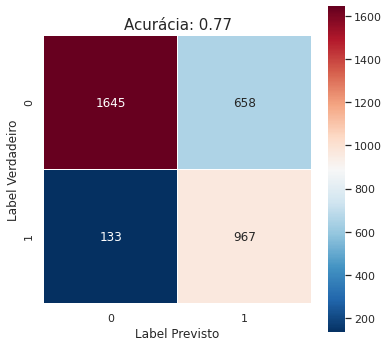

In [15]:
params = {'silent'       : 1,
          'objective'    : 'binary:logistic',
          'eval_metric'  : 'auc',
          'booster'      : 'gbtree',
          'lambda'       : 0.026834336727892413,
          'alpha'        : 0.0006039910566283139,
          'max_depth'    : 8,
          'eta'          : 0.0006565933008274129,
          'gamma'        : 0.0012661208934645076,
          'grow_policy' : 'depthwise'}


#modelo_xgb_v4 = xgb.XGBClassifier(**study_v2.best_params)
modelo_xgb_v4 = xgb.XGBClassifier(**params)

# Treinando o modelo
modelo_xgb_v4.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v4.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v4 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v4 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v4), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Bayesian Optimization

In [16]:
#!pip install scikit-optimize --upgrade

In [17]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold


In [84]:
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(n_jobs       = -1,
                                objective      = 'binary:logistic',
                                eval_metric    = 'auc',
                                learning_rate  = 0.2,
                                silent         = 1,
                                early_stopping = 20,
                                n_estimators   = 200,
                                tree_method    = 'approx'
    ),
    search_spaces = {
        'min_child_weight'  : (15, 20),
        'max_depth'         : (6, 8),
        'max_delta_step'    : (0, 20),
        'subsample'         : (0.01, 1.0, 'uniform'),
        'colsample_bytree'  : (0.01, 1.0, 'uniform'),
        'colsample_bylevel' : (0.01, 1.0, 'uniform'),
        'reg_lambda'        : (0, 1000, 'log-uniform'),
        'reg_alpha'         : (0, 100, 'log-uniform'),
        'gamma'             : (1e-2, 0.5, 'log-uniform'),
        'min_child_weight'  : (0, 20),
        'scale_pos_weight'  : (0, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits     = 6,
        shuffle      = True,
        random_state = SEED
    ),
    n_jobs  = -1,
    n_iter  = 20,   
    verbose = 0,
    refit   = True,
    random_state = SEED
)

def status_print(optim_result):
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")

In [85]:
# Treinamento do modelo
result = bayes_cv_tuner.fit(X_treino, y_treino, callback=status_print)

Model #1
Best ROC-AUC: 0.8422
Best params: OrderedDict([('colsample_bylevel', 0.4160029192647807), ('colsample_bytree', 0.7304484857455519), ('gamma', 0.38451629413594224), ('max_delta_step', 6), ('max_depth', 7), ('min_child_weight', 8), ('reg_alpha', 35), ('reg_lambda', 740), ('scale_pos_weight', 152), ('subsample', 0.6513136724634089)])

Model #2
Best ROC-AUC: 0.8447
Best params: OrderedDict([('colsample_bylevel', 0.8390144719977516), ('colsample_bytree', 0.8844821246070537), ('gamma', 0.03277062133261745), ('max_delta_step', 19), ('max_depth', 8), ('min_child_weight', 1), ('reg_alpha', 14), ('reg_lambda', 354), ('scale_pos_weight', 318), ('subsample', 0.9539453486878958)])

Model #3
Best ROC-AUC: 0.8447
Best params: OrderedDict([('colsample_bylevel', 0.8390144719977516), ('colsample_bytree', 0.8844821246070537), ('gamma', 0.03277062133261745), ('max_delta_step', 19), ('max_depth', 8), ('min_child_weight', 1), ('reg_alpha', 14), ('reg_lambda', 354), ('scale_pos_weight', 318), ('subs

In [86]:
result.best_params_

OrderedDict([('colsample_bylevel', 0.5479690370134094),
             ('colsample_bytree', 0.9208091341729433),
             ('gamma', 0.0697400151786318),
             ('max_delta_step', 17),
             ('max_depth', 7),
             ('min_child_weight', 1),
             ('reg_alpha', 57),
             ('reg_lambda', 26),
             ('scale_pos_weight', 193),
             ('subsample', 0.8276864968834418)])

Acurácia: 78.05%
Sensibilidade : 0.9936363636363637
Especificidade : 0.6786799826313504


              precision    recall  f1-score   support

           0       1.00      0.68      0.81      2303
           1       0.60      0.99      0.75      1100

    accuracy                           0.78      3403
   macro avg       0.80      0.84      0.78      3403
weighted avg       0.87      0.78      0.79      3403



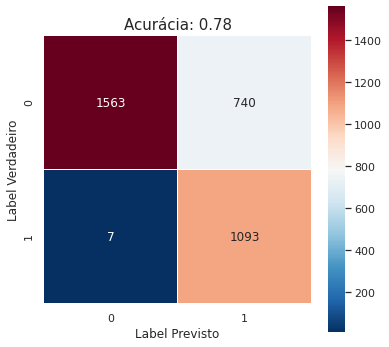

In [87]:
modelo_xgb_v5 = xgb.XGBClassifier(**result.best_params_)

# Treinando o modelo
modelo_xgb_v5.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v5.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v5 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v5 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v5), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

# Parte 05. Realizando novas previsões

In [ ]:
# Carregando o dataset de testes 
teste  = pd.read_csv(r'to_be_scored.csv')
print('Quantidade de registros e colunas: ',teste.shape)

# Removendo colunas que não serão utilizadas no treinamento
teste = teste.drop(['Tempo','Estação','Movimentação','LAT','LONG'], axis = 1)

# Visualizando os primeiros registros
teste.head()

In [ ]:
# Padronizando os dados (0 para a média, 1 para o desvio padrão)
teste_scaler = StandardScaler().fit_transform(teste)

# Realizando previsoes com dados de teste(usando modelo NAO BALANCEADO)
y_pred_test = modelo_xgb_v5.predict(teste_scaler)


In [ ]:
# Salvando na coluna target
teste['TARGET'] = y_pred_test
teste['TARGET'] = np.where(teste['TARGET'] == 0, 'NORMAL', 'REABASTECER')

# Visualizando os ultimos registros
teste.tail()

In [ ]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [ ]:
# Gravando resultado em csv
teste.to_csv('results_xgb_v2.csv',index=False)